In [2]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2.10.1


In [13]:
# !git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2095, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2095 (delta 2), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2095/2095), 15.07 MiB | 37.27 MiB/s, done.
Resolving deltas: 100% (660/660), done.


In [15]:
# !pip install split-folders 

In [16]:
# import splitfolders
# import os

In [17]:
# path = "Sign-Language-Digits-Dataset/Dataset"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

Copying files: 2062 files [00:00, 7405.55 files/s]


In [3]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [4]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 1438 images belonging to 10 classes.
Found 304 images belonging to 10 classes.
Found 320 images belonging to 10 classes.


In [5]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-09 23:32:46.944300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-09 23:32:46.944351: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-09 23:32:46.944381: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ac522412c7b2): /proc/driver/nvidia/version does not exist
2023-09-09 23:32:46.944667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
##DEFINIMOS EL MODELO
num_classes = 10
epochs = 50

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [8]:
## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=["accuracy"])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

metric = 'val_accuracy'

checkpointer = ModelCheckpoint(filepath='model-01', verbose=1, save_best_only=True,
                               monitor = metric, mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.000001)

model= model.fit(train_generator,validation_data = valid_generator, 
                             callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 3.5456 - accuracy: 0.1154
Epoch 1: val_accuracy improved from -inf to 0.10855, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 106s 2s/step - loss: 3.5456 - accuracy: 0.1154 - val_loss: 3.4308 - val_accuracy: 0.1086 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 3.4457 - accuracy: 0.1293
Epoch 2: val_accuracy improved from 0.10855 to 0.23026, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 107s 2s/step - loss: 3.4457 - accuracy: 0.1293 - val_loss: 3.3729 - val_accuracy: 0.2303 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 3.3812 - accuracy: 0.1871
Epoch 3: val_accuracy did not improve from 0.23026
45/45 [==============================] - 102s 2s/step - loss: 3.3812 - accuracy: 0.1871 - val_loss: 3.2875 - val_accuracy: 0.2270 - lr: 0.0010
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 3.2772 - accuracy: 0.2274
Epoch 4: val_accuracy improved from 0.23026 to 0.28947, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 106s 2s/step - loss: 3.2772 - accuracy: 0.2274 - val_loss: 3.1611 - val_accuracy: 0.2895 - lr: 0.0010
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 3.1473 - accuracy: 0.2698
Epoch 5: val_accuracy improved from 0.28947 to 0.35197, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 106s 2s/step - loss: 3.1473 - accuracy: 0.2698 - val_loss: 2.9885 - val_accuracy: 0.3520 - lr: 0.0010
Epoch 6/50
45/45 [==============================] - ETA: 0s - loss: 3.0146 - accuracy: 0.3150
Epoch 6: val_accuracy did not improve from 0.35197
45/45 [==============================] - 102s 2s/step - loss: 3.0146 - accuracy: 0.3150 - val_loss: 2.9393 - val_accuracy: 0.3191 - lr: 0.0010
Epoch 7/50
45/45 [==============================] - ETA: 0s - loss: 2.8681 - accuracy: 0.3825
Epoch 7: val_accuracy improved from 0.35197 to 0.47368, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 107s 2s/step - loss: 2.8681 - accuracy: 0.3825 - val_loss: 2.6819 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 8/50
45/45 [==============================] - ETA: 0s - loss: 2.8049 - accuracy: 0.3818
Epoch 8: val_accuracy improved from 0.47368 to 0.56579, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 106s 2s/step - loss: 2.8049 - accuracy: 0.3818 - val_loss: 2.5042 - val_accuracy: 0.5658 - lr: 0.0010
Epoch 9/50
45/45 [==============================] - ETA: 0s - loss: 2.6610 - accuracy: 0.4423
Epoch 9: val_accuracy improved from 0.56579 to 0.66447, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 105s 2s/step - loss: 2.6610 - accuracy: 0.4423 - val_loss: 2.2776 - val_accuracy: 0.6645 - lr: 0.0010
Epoch 10/50
45/45 [==============================] - ETA: 0s - loss: 2.4895 - accuracy: 0.5167
Epoch 10: val_accuracy did not improve from 0.66447
45/45 [==============================] - 103s 2s/step - loss: 2.4895 - accuracy: 0.5167 - val_loss: 2.3294 - val_accuracy: 0.6086 - lr: 0.0010
Epoch 11/50
45/45 [==============================] - ETA: 0s - loss: 2.3869 - accuracy: 0.5570
Epoch 11: val_accuracy improved from 0.66447 to 0.73684, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 106s 2s/step - loss: 2.3869 - accuracy: 0.5570 - val_loss: 2.0224 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 12/50
45/45 [==============================] - ETA: 0s - loss: 2.2506 - accuracy: 0.5981
Epoch 12: val_accuracy improved from 0.73684 to 0.74013, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 103s 2s/step - loss: 2.2506 - accuracy: 0.5981 - val_loss: 1.8973 - val_accuracy: 0.7401 - lr: 0.0010
Epoch 13/50
45/45 [==============================] - ETA: 0s - loss: 2.1383 - accuracy: 0.6481
Epoch 13: val_accuracy improved from 0.74013 to 0.80263, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 106s 2s/step - loss: 2.1383 - accuracy: 0.6481 - val_loss: 1.7412 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 14/50
45/45 [==============================] - ETA: 0s - loss: 2.0390 - accuracy: 0.6836
Epoch 14: val_accuracy did not improve from 0.80263
45/45 [==============================] - 102s 2s/step - loss: 2.0390 - accuracy: 0.6836 - val_loss: 1.7346 - val_accuracy: 0.8026 - lr: 0.0010
Epoch 15/50
45/45 [==============================] - ETA: 0s - loss: 2.0043 - accuracy: 0.6780
Epoch 15: val_accuracy improved from 0.80263 to 0.87500, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 106s 2s/step - loss: 2.0043 - accuracy: 0.6780 - val_loss: 1.5612 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 16/50
45/45 [==============================] - ETA: 0s - loss: 1.8324 - accuracy: 0.7399
Epoch 16: val_accuracy did not improve from 0.87500
45/45 [==============================] - 157s 4s/step - loss: 1.8324 - accuracy: 0.7399 - val_loss: 1.5994 - val_accuracy: 0.8257 - lr: 0.0010
Epoch 17/50
45/45 [==============================] - ETA: 0s - loss: 1.8348 - accuracy: 0.7510
Epoch 17: val_accuracy did not improve from 0.87500
45/45 [==============================] - 103s 2s/step - loss: 1.8348 - accuracy: 0.7510 - val_loss: 1.6678 - val_accuracy: 0.8355 - lr: 0.0010
Epoch 18/50
45/45 [==============================] - ETA: 0s - loss: 1.7307 - accuracy: 0.7990
Epoch 18: val_accuracy improved from 0.87500 to 0.89145, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 107s 2s/step - loss: 1.7307 - accuracy: 0.7990 - val_loss: 1.4797 - val_accuracy: 0.8914 - lr: 0.0010
Epoch 19/50
45/45 [==============================] - ETA: 0s - loss: 1.6890 - accuracy: 0.7976
Epoch 19: val_accuracy did not improve from 0.89145
45/45 [==============================] - 105s 2s/step - loss: 1.6890 - accuracy: 0.7976 - val_loss: 1.4524 - val_accuracy: 0.8849 - lr: 0.0010
Epoch 20/50
45/45 [==============================] - ETA: 0s - loss: 1.5836 - accuracy: 0.8533
Epoch 20: val_accuracy did not improve from 0.89145
45/45 [==============================] - 123s 3s/step - loss: 1.5836 - accuracy: 0.8533 - val_loss: 1.4473 - val_accuracy: 0.8914 - lr: 0.0010
Epoch 21/50
45/45 [==============================] - ETA: 0s - loss: 1.6223 - accuracy: 0.8241
Epoch 21: val_accuracy improved from 0.89145 to 0.89474, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 105s 2s/step - loss: 1.6223 - accuracy: 0.8241 - val_loss: 1.4418 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 22/50
45/45 [==============================] - ETA: 0s - loss: 1.5711 - accuracy: 0.8414
Epoch 22: val_accuracy improved from 0.89474 to 0.92105, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 106s 2s/step - loss: 1.5711 - accuracy: 0.8414 - val_loss: 1.3591 - val_accuracy: 0.9211 - lr: 0.0010
Epoch 23/50
45/45 [==============================] - ETA: 0s - loss: 1.5292 - accuracy: 0.8581
Epoch 23: val_accuracy improved from 0.92105 to 0.93750, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 106s 2s/step - loss: 1.5292 - accuracy: 0.8581 - val_loss: 1.3128 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 24/50
45/45 [==============================] - ETA: 0s - loss: 1.5259 - accuracy: 0.8686
Epoch 24: val_accuracy did not improve from 0.93750
45/45 [==============================] - 99s 2s/step - loss: 1.5259 - accuracy: 0.8686 - val_loss: 1.3767 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 25/50
45/45 [==============================] - ETA: 0s - loss: 1.4980 - accuracy: 0.8644
Epoch 25: val_accuracy did not improve from 0.93750
45/45 [==============================] - 99s 2s/step - loss: 1.4980 - accuracy: 0.8644 - val_loss: 1.3453 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 26/50
45/45 [==============================] - ETA: 0s - loss: 1.4486 - accuracy: 0.8853
Epoch 26: val_accuracy did not improve from 0.93750
45/45 [==============================] - 117s 3s/step - loss: 1.4486 - accuracy: 0.8853 - val_loss: 1.3660 - val_accuracy: 0.9309 - 

INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 121s 3s/step - loss: 1.4144 - accuracy: 0.8964 - val_loss: 1.3054 - val_accuracy: 0.9474 - lr: 2.0000e-04
Epoch 28/50
45/45 [==============================] - ETA: 0s - loss: 1.3521 - accuracy: 0.9221
Epoch 28: val_accuracy did not improve from 0.94737
45/45 [==============================] - 108s 2s/step - loss: 1.3521 - accuracy: 0.9221 - val_loss: 1.3170 - val_accuracy: 0.9309 - lr: 2.0000e-04
Epoch 29/50
45/45 [==============================] - ETA: 0s - loss: 1.3883 - accuracy: 0.9103
Epoch 29: val_accuracy did not improve from 0.94737
45/45 [==============================] - 104s 2s/step - loss: 1.3883 - accuracy: 0.9103 - val_loss: 1.2847 - val_accuracy: 0.9276 - lr: 2.0000e-04
Epoch 30/50
45/45 [==============================] - ETA: 0s - loss: 1.3644 - accuracy: 0.9145
Epoch 30: val_accuracy did not improve from 0.94737
45/45 [==============================] - 131s 3s/step - loss: 1.3644 - accuracy: 0.9145 - val_loss: 1.3279 - val_accur

INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 107s 2s/step - loss: 1.3280 - accuracy: 0.9263 - val_loss: 1.2715 - val_accuracy: 0.9507 - lr: 2.0000e-04
Epoch 33/50
45/45 [==============================] - ETA: 0s - loss: 1.3355 - accuracy: 0.9200
Epoch 33: val_accuracy improved from 0.95066 to 0.95395, saving model to model-01


INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 107s 2s/step - loss: 1.3355 - accuracy: 0.9200 - val_loss: 1.2970 - val_accuracy: 0.9539 - lr: 2.0000e-04
Epoch 34/50
45/45 [==============================] - ETA: 0s - loss: 1.3661 - accuracy: 0.9145
Epoch 34: val_accuracy did not improve from 0.95395
45/45 [==============================] - 103s 2s/step - loss: 1.3661 - accuracy: 0.9145 - val_loss: 1.3187 - val_accuracy: 0.9441 - lr: 2.0000e-04
Epoch 35/50
45/45 [==============================] - ETA: 0s - loss: 1.3443 - accuracy: 0.9145
Epoch 35: val_accuracy did not improve from 0.95395
45/45 [==============================] - 103s 2s/step - loss: 1.3443 - accuracy: 0.9145 - val_loss: 1.3142 - val_accuracy: 0.9408 - lr: 2.0000e-04
Epoch 36/50
45/45 [==============================] - ETA: 0s - loss: 1.3218 - accuracy: 0.9291
Epoch 36: val_accuracy did not improve from 0.95395
45/45 [==============================] - 104s 2s/step - loss: 1.3218 - accuracy: 0.9291 - val_loss: 1.3237 - val_accur

INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 111s 2s/step - loss: 1.3310 - accuracy: 0.9172 - val_loss: 1.2920 - val_accuracy: 0.9572 - lr: 4.0000e-05
Epoch 38/50
45/45 [==============================] - ETA: 0s - loss: 1.3241 - accuracy: 0.9235
Epoch 38: val_accuracy did not improve from 0.95724
45/45 [==============================] - 103s 2s/step - loss: 1.3241 - accuracy: 0.9235 - val_loss: 1.3699 - val_accuracy: 0.9276 - lr: 4.0000e-05
Epoch 39/50
45/45 [==============================] - ETA: 0s - loss: 1.3309 - accuracy: 0.9291
Epoch 39: val_accuracy did not improve from 0.95724
45/45 [==============================] - 108s 2s/step - loss: 1.3309 - accuracy: 0.9291 - val_loss: 1.2994 - val_accuracy: 0.9441 - lr: 8.0000e-06
Epoch 40/50
45/45 [==============================] - ETA: 0s - loss: 1.3343 - accuracy: 0.9305
Epoch 40: val_accuracy did not improve from 0.95724
45/45 [==============================] - 106s 2s/step - loss: 1.3343 - accuracy: 0.9305 - val_loss: 1.2677 - val_accur

INFO:tensorflow:Assets written to: model-01/assets


INFO:tensorflow:Assets written to: model-01/assets


45/45 [==============================] - 106s 2s/step - loss: 1.3209 - accuracy: 0.9291 - val_loss: 1.2498 - val_accuracy: 0.9638 - lr: 8.0000e-06
Epoch 47/50
45/45 [==============================] - ETA: 0s - loss: 1.3421 - accuracy: 0.9159
Epoch 47: val_accuracy did not improve from 0.96382
45/45 [==============================] - 104s 2s/step - loss: 1.3421 - accuracy: 0.9159 - val_loss: 1.3121 - val_accuracy: 0.9441 - lr: 8.0000e-06
Epoch 48/50
45/45 [==============================] - ETA: 0s - loss: 1.3433 - accuracy: 0.9186
Epoch 48: val_accuracy did not improve from 0.96382
45/45 [==============================] - 101s 2s/step - loss: 1.3433 - accuracy: 0.9186 - val_loss: 1.2442 - val_accuracy: 0.9539 - lr: 1.6000e-06
Epoch 49/50
45/45 [==============================] - ETA: 0s - loss: 1.3251 - accuracy: 0.9242
Epoch 49: val_accuracy did not improve from 0.96382
45/45 [==============================] - 99s 2s/step - loss: 1.3251 - accuracy: 0.9242 - val_loss: 1.3077 - val_accura

In [11]:
preds_test = model.model.predict(test_generator)

10/10 [==============================] - 7s 689ms/step


In [12]:
evaluate_test = model.model.evaluate(test_generator)

10/10 [==============================] - 6s 634ms/step - loss: 1.2942 - accuracy: 0.9500


In [13]:
evaluate_test

[1.2941697835922241, 0.949999988079071]

In [14]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 4, 4, 4,
       4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 9, 5, 5, 6, 2, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 6, 6, 4, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 7, 8, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 7, 9, 7, 8, 8, 8, 9, 8, 8, 8, 8,
       8, 8, 8, 4, 8, 8, 8, 8, 8, 4, 8, 8, 8, 8, 8, 8, 8, 9, 7, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 9, 9, 9,

In [15]:
y_real_test = test_generator.classes
y_real_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [16]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.921875

In [17]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[31,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 1, 31,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 32,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 31,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, 27,  3,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0, 30,  0,  0,  0,  2],
       [ 0,  0,  2,  0,  1,  0, 29,  0,  0,  0],
       [ 1,  0,  0,  0,  1,  0,  2, 26,  1,  1],
       [ 0,  0,  0,  0,  2,  0,  0,  1, 27,  2],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, 31]])

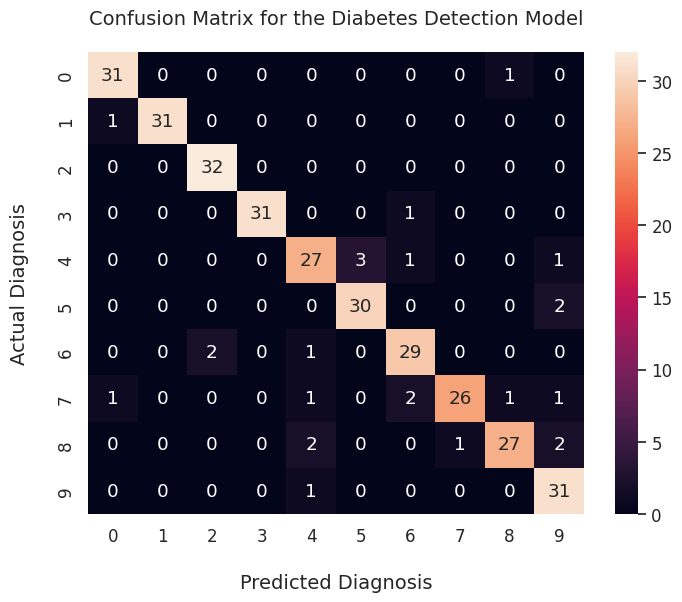

In [18]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [20]:
preds_val = model.model.predict(valid_generator)

10/10 [==============================] - 6s 540ms/step


In [22]:
evaluate_val = model.model.evaluate(valid_generator)

10/10 [==============================] - 7s 663ms/step - loss: 1.3180 - accuracy: 0.9474


In [23]:
evaluate_val

[1.3179888725280762, 0.9473684430122375]

In [24]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 7, 7, 7, 7, 7, 7,
       6, 7, 8, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 9, 8, 7, 8, 8, 8, 7, 8, 8, 9, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [25]:
y_real_val = valid_generator.classes
y_real_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [26]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9572368421052632

In [27]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 29,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1, 28,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0, 30,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 31,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 31,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  2, 25,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  2, 28,  1],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 29]])

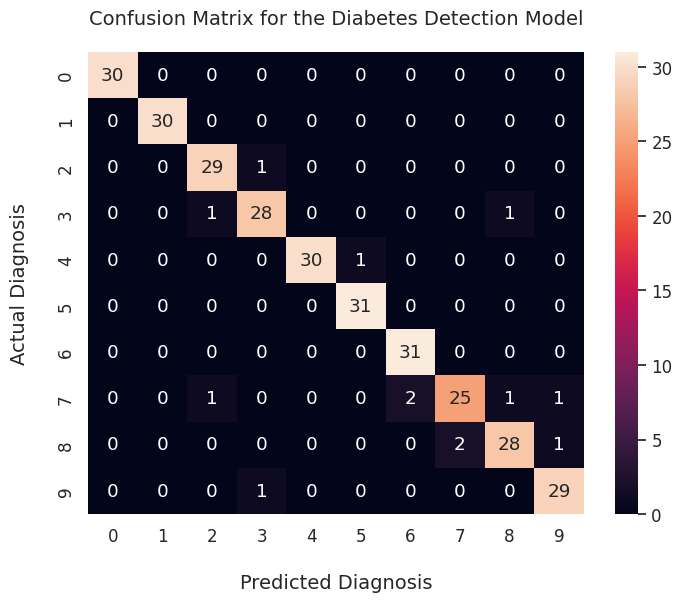

In [28]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()